In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [ ]:

OUTPUT_DIR = "../data/data_outputs"


TOP_K = 5  # For nearest neighbor search
SYN_SOURCES = ["ctgan", "copula", "tvae"]

In [ ]:
# Load both train and holdout sets
train_df = pd.read_csv(os.path.join(OUTPUT_DIR, "train_df.csv"))
holdout_df = pd.read_csv(os.path.join(OUTPUT_DIR, "holdout_df.csv"))

# Load synthetic data
synthetic_data = {
    model: pd.read_csv(os.path.join(OUTPUT_DIR, f"synthetic_{model}.csv"))
    for model in SYN_SOURCES
}

In [ ]:
# Prep attack data
# Get avg distance for k=5 nearest neighbors
def get_membership_scores(real_df, synthetic_df):

    # Use Nearest Neighbors to calculate average distance to top-k synthetic samples
    nn = NearestNeighbors(n_neighbors=TOP_K)
    nn.fit(synthetic_df)
    distances, _ = nn.kneighbors(real_df)
    avg_dist = distances.mean(axis=1)
    return avg_dist


Running MIA for: ctgan
AUC: 0.506 | Precision: 0.751 | Recall: 0.501

Running MIA for: copula
AUC: 0.500 | Precision: 0.749 | Recall: 0.499

Running MIA for: tvae
AUC: 0.500 | Precision: 0.752 | Recall: 0.501


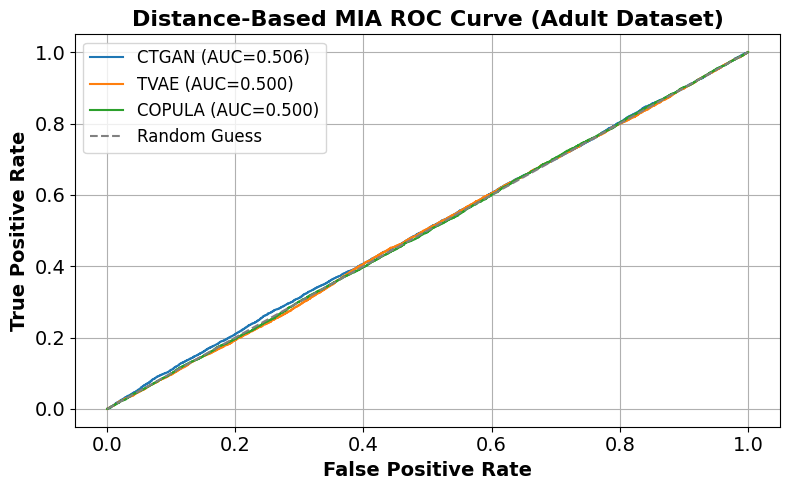

In [ ]:
# Fixed plot order and color scheme
model_order = ["CTGAN", "TVAE", "COPULA"]
color_map = {
    "CTGAN": "tab:blue",
    "TVAE": "tab:orange",
    "COPULA": "tab:green"
}



# Save full distance scores for later worst-case analysis
all_distances = {}
results = {}

for model, syn_df in synthetic_data.items():
    print(f"\nRunning MIA for: {model}")

    # Model names to upper case
    model_name = model.upper()

    # Match column order to real data
    syn_df = syn_df[train_df.columns]

    # Compute distances
    train_dist = get_membership_scores(train_df, syn_df)
    holdout_dist = get_membership_scores(holdout_df, syn_df)

    # Save for later use, for worst-case analysis
    all_distances[model_name] = {
        "train": train_dist,
        "holdout": holdout_dist
    }

    # Combine scores and labels for ROC
    scores = np.concatenate([train_dist, holdout_dist])
    labels = np.array([1] * len(train_dist) + [0] * len(holdout_dist))  # 1 = member


    # Invert scores, lower distance = higher membership likelihood
    scores = -scores

    # Compute metrics
    auc = roc_auc_score(labels, scores)
    precision = precision_score(labels, scores > np.median(scores))
    recall = recall_score(labels, scores > np.median(scores))
    fpr, tpr, _ = roc_curve(labels, scores)

    # Store metrics
    results[model_name] = {
        "auc": auc,
        "precision": precision,
        "recall": recall,
        "fpr": fpr,
        "tpr": tpr,
    }

    print(f"AUC: {auc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}")


    

# Plot for AUC
plt.figure(figsize=(8, 5))

for model in model_order:
    if model in results:
        fpr = results[model]["fpr"]
        tpr = results[model]["tpr"]
        auc = results[model]["auc"]
        plt.plot(fpr, tpr, label=f"{model} (AUC={auc:.3f})", color=color_map[model])

# Add random guess reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

# Axis labels and styling
font_size = 14
plt.xlabel("False Positive Rate", fontsize=font_size, fontweight='bold')
plt.ylabel("True Positive Rate", fontsize=font_size, fontweight='bold')
plt.title("Distance-Based MIA ROC Curve (Adult Dataset)", fontsize=font_size + 2, fontweight='bold')
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size - 2)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "distance_based_roc_curve.png"), dpi=300)
plt.show()



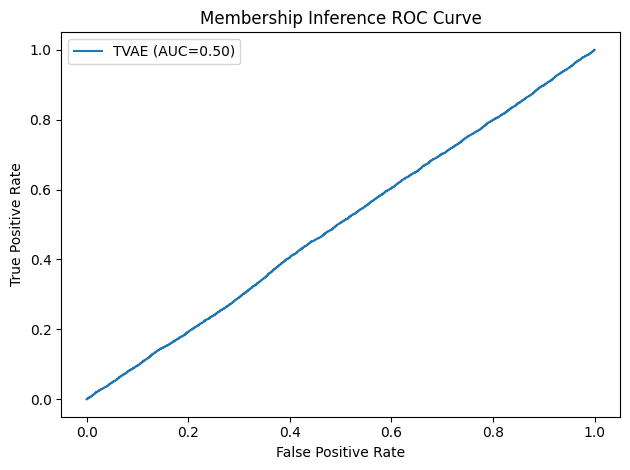

In [ ]:
# 
#plt.title("Membership Inference ROC Curve")
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")
#plt.plot(fpr, tpr, label=f"{model.upper()} (AUC={auc:.2f})")

##plt.legend()
#plt.tight_layout()
#plt.savefig(os.path.join(OUTPUT_DIR, "mia_roc_curve.png"))
#plt.show()

In [ ]:
# Model-based MIA

print("\nRunning model-based MIA...")

model_mia_results = {}

for model, syn_df in synthetic_data.items():

    # Use train
    syn_df = syn_df[train_df.columns]

    # Get NN distances to synthetic data
    train_dist = get_membership_scores(train_df, syn_df) #known to be members
    holdout_dist = get_membership_scores(holdout_df, syn_df) #known to be non-members

    # Prepare features for labeled dataset
    X = np.concatenate([train_dist, holdout_dist]).reshape(-1, 1) # input: distance
    y = np.array([1]*len(train_dist) + [0]*len(holdout_dist)) # label: 1=training_member, 0=holdout_non_member

    # Train/test split for attacker model
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    # Logistic regression classifier as MIA model
    mia_clf = LogisticRegression()
    mia_clf.fit(X_train, y_train)

    # Predict probabilities
    y_proba = mia_clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)

    model_mia_results[model] = auc
    print(f"Model-based MIA AUC for {model}: {auc:.3f}")



Running model-based MIA...
Model-based MIA AUC for ctgan: 0.519
Model-based MIA AUC for copula: 0.503
Model-based MIA AUC for tvae: 0.498


/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_st

In [8]:
import json
with open(os.path.join(OUTPUT_DIR, "model_mia_auc.json"), "w") as f:
    json.dump(model_mia_results, f, indent=2)


Worst-Case MIA (Top 10% Most Vulnerable Records)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

print("\n--- Worst-Case MIA (Top 10% Closest Records) ---")

worst_case_auc_results = {}

for model in all_distances:
    train_dist = all_distances[model]["train"]
    holdout_dist = all_distances[model]["holdout"]

    # Get top 10% closest records (most vulnerable)
    n_train = int(0.10 * len(train_dist))
    n_holdout = int(0.10 * len(holdout_dist))

    vulnerable_train = np.argsort(train_dist)[:n_train]
    vulnerable_holdout = np.argsort(holdout_dist)[:n_holdout]

    # Build dataset
    X_vuln = np.concatenate([
        train_dist[vulnerable_train],
        holdout_dist[vulnerable_holdout]
    ]).reshape(-1, 1)

    y_vuln = np.array([1]*n_train + [0]*n_holdout)

    # Train logistic regression attack model
    clf = LogisticRegression()
    clf.fit(X_vuln, y_vuln)
    y_pred = clf.predict_proba(X_vuln)[:, 1]
    auc = roc_auc_score(y_vuln, y_pred)

    worst_case_auc_results[model] = auc
    print(f"{model.upper()}: Worst-case MIA AUC = {auc:.3f}")



--- Worst-Case MIA (Top 10% Closest Records) ---
CTGAN: Worst-case MIA AUC = 0.556
COPULA: Worst-case MIA AUC = 0.507
TVAE: Worst-case MIA AUC = 0.514


/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_st

In [10]:
with open(os.path.join(OUTPUT_DIR, "worst_case_mia_auc.json"), "w") as f:
    json.dump(worst_case_auc_results, f, indent=2)
